In [84]:
#FUNCTION TO IMPORT ACCELEROMETER DATA
import csv
import os
import numpy as np
import scipy.stats as stats
import random
import math
import matplotlib.pyplot as plt


print(os.getcwd())
my_directory = '/Users/apara/Documents/GitHub/hsl_python/SpaceVestibExperiment' 
folder = 'ak1' #change this based on person

def import_accel(rootdir, foldername):

    directory = rootdir + '/' + foldername + '/Acc' 

    os.chdir(directory)

    for r, d, files in os.walk(directory):
        for filename in files:
            if 'si' in filename and 'up' in filename:
                si_up = np.loadtxt(filename, delimiter = ',', skiprows=1, usecols = (1,2,3,4,5,6))
            elif 'si' in filename and 'p' in filename:
                si_p = np.loadtxt(filename, delimiter = ',', skiprows=1, usecols = (1,2,3,4,5,6))
            elif 'st' in filename and 'up' in filename: 
                st_up = np.loadtxt(filename, delimiter = ',', skiprows=1, usecols = (1,2,3,4,5,6))
            elif 'st' in filename and 'p' in filename: 
                st_p = np.loadtxt(filename, delimiter = ',', skiprows=1, usecols = (1,2,3,4,5,6))    
    return si_up.transpose(), si_p.transpose(), st_up.transpose(), st_p.transpose()

ak_accel = import_accel(my_directory, folder) #ak_accel[0] = 6x400 matrix (only up1,sit)

/Users/apara/Documents/GitHub/hsl_python/SpaceVestibExperiment/ak1/Acc
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [93]:
#ALL THE RAW STATS: Spearman, T-test, MW, KW, Wilcoxon
#i = 0,1,2,3 = Upsi,psi, upst, pst
#j = 0,1,2,3,4,5, = x,y,z,...  -- WANT 0 and 2!!
subj_arr = ak_accel

#t1 and t2 are of the form: ak_accel[0][0] first number is UPsit/Psit/UPstand/Pstand, second is type of acceleration
#so first numbers should be different, second should be the same
def spearman(t1, t2):
    minlength = min(len(t1), len(t2))
    trial1 = t1[0:minlength]
    trial2 = t2[0:minlength]
    spearman = stats.spearmanr(trial1, trial2)
    return [spearman[0], spearman[1]]

print(spearman(ak_accel[1][0], ak_accel[0][0]))

#T-Test AP
t_test_arr = np.zeros([4,2])
for i in range(4):
    for k in range(4):
        for j in [0,2]:
            minlength = min(len(subj_arr[i][j]), len(subj_arr[i][k]))
            trial1 = subj_arr[i][k][0:minlength]
            trial2 = subj_arr[i][k][0:minlength]
            print(stats.ttest_ind(trial1,trial2))

[-0.10040516796821018, 0.044493058016725893]
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [11]:
#These are all Vedant's stats functions from the shimmer file
def scaled_correlation_time(signal1, signal2):
    signal1 = (signal1 - np.mean(signal1))/np.std(signal1)
    signal2 = (signal2 - np.mean(signal2))/np.std(signal2)
    acorr = np.correlate(signal1, signal2, mode='full')
    acorr = acorr[(acorr.size // 2 ):] / np.max(acorr)
#     plt.plot(acorr)
    tau = np.argmax([acorr < 1/np.exp(1)])
    return tau / len(acorr)

def signal_statistics(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    skewness = stats.skew(signal)
    kurtosis = stats.kurtosis(signal)
    maximum = np.max(signal)
    minimum = np.min(signal)
    iqr = stats.iqr(signal)
    variation = stats.variation(signal)
    entropy = stats.entropy(np.abs(signal))
    corrtime = scaled_correlation_time(signal,signal)        
    return np.asarray([mean, std, skewness, kurtosis, maximum, minimum, variation, entropy])

def spectrum_statistics(signal):
    fs,pxx = sig.periodogram(signal, fs = 50, nfft = 1000, scaling = 'density', detrend = 'constant')
#   plt.plot(fs,pxx)
    #plt.xlim(0,0.1)
    peak = fs[np.argmax(pxx)]
    peakmag = np.max(pxx)
    integral = np.trapz(pxx,fs)
    energy = np.dot(pxx,pxx)
    shannon = np.sum(pxx*np.log(1/pxx))
    return [peak, peakmag, integral, energy, shannon]


In [12]:
#outputs a 4*6*8 array -- all the signal stats (all 4 phases, all 6 directions) per person

def create_array(person):
    signal_list = []
    for run in range(4):
        for measure in range(6):
            new_list_measure = [signal_statistics(ak_accel[run][measure])]
            signal_list.append(new_list_measure)

    signal_arr = np.asarray(signal_list)
    signal_arr = signal_arr.reshape(4,6,8)

    return signal_arr

In [69]:
#Filter Function -- Butterworth




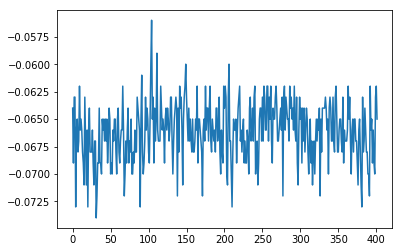

In [70]:
i = 0#input number from 0-3; representing UP-SI, P-SI, UP-ST, P-ST
j = 0 #input number from 0-5; representing x,y,z linear and x,y,z rotational

plt.plot(ak_accel[i][j])
plt.show()

#Frequency of 1 Hz

In [26]:
#Canonical Posture Analysis
#This will include:
    # 2D sway area
    # RMS acceleration (sqrt x,y,z) DONE
    # normalized path length DONE
    # sway range DONE

#AP = z; ML = x; DV = y

#ONLY for linear acceleration
def canonical_posture(subj, trialnum):
    dataset = subj[trialnum] 
    
    #rms
    rms_list = []
    for measure in range(3):
        sq_sum = 0
        for i in dataset[measure]:
            sq_sum += i**2
        rms_list.append(np.sqrt(sq_sum/len(dataset[measure])))
    rms_ML = rms_list[0]
    rms_AP = rms_list[2]
    rms_DV = rms_list[1]
    
    total_rms = np.sqrt(rms_ML**2 + rms_AP**2 + rms_DV**2)
    rmsr_ML = rms_list[0]/total_rms
    rmsr_AP = rms_list[2]/total_rms
    rmsr_DV = rms_list[1]/total_rms
    rmsr_list = [rmsr_ML, rmsr_DV, rmsr_AP]
    
    
    #2d sway
    AP = dataset[2] * 9.8
    ML = dataset[0] * 9.8
    m = 72
    theta = 5*math.pi / 180
    window = len(AP)//72
    AP_max = []
    ML_max = []
    r_max = []
    count_ind = 0
    while count_ind <= len(AP)-window:
        max_val_AP = max(AP[count_ind],AP[count_ind+window])
        AP_max.append(max_val_AP)

        max_val_ML = max(ML[count_ind],AP[count_ind+window])
        ML_max.append(max_val_ML)

        r_max.append(np.sqrt(max_val_ML**2 + max_val_AP**2))

        count_ind = count_ind+window

    sway_area = 0
    for i in range(len(r_max)-1):
        sway_area += r_max[i] * r_max[i+1] * math.sin(theta)/2
    sway_area = sway_area/72
    
    
    #normalized path length in AP and ML direction    
    #npl
    sum_of_elementsx = [];
    sum_of_elementsz = [];

    for point in range(len(subj)-2):
        sum_of_elementsx.append(subj[trialnum][0][point+1] - subj[trialnum][0][point])
    for point2 in range(len(subj)-2):
        sum_of_elementsz.append(subj[trialnum][2][point2+1] - subj[trialnum][2][point2])
    
    #need to check the time division
    nplML = (1/20)*sum(sum_of_elementsx)
    nplAP = (1/20)*sum(sum_of_elementsz)
    
    npl = np.array([nplAP,nplML])
    
    #range
    maxML = max(subj[trialnum][0])
    minML = min(subj[trialnum][0])
    rangeML = abs(maxML - minML)
    
    maxAP = max(subj[trialnum][2])
    minAP = min(subj[trialnum][2])
    rangeAP = abs(maxAP - minAP)
    
    resultant_range = math.sqrt(rangeML**2 + rangeAP**2)
    
    swayrange = np.array([rangeAP,rangeML,resultant_range])
    
    #STD
    std_list = []
    for i in range(3):
        std_list.append(np.std(dataset[i]))
        
    #RMS Error
    rms_error_list = []
    for i in range(3):
        sum_list = []
        for j in range(len(dataset[i])):
            sum_list.append((dataset[i][j]-rms_list[i])**2)
        rms_error_list.append(math.sqrt(sum(sum_list)/len(sum_list)))
    
    rms_total_error = 0    
    for i in range(3):
        rms_total_error += ((rms_list[i] * (rms_list[0]**2 + rms_list[1]**2 + rms_list[2]**2)**-0.5)*rms_error_list[i])**2
    rms_total_error = math.sqrt(rms_total_error)
    
    rmsr_error_list = []
    for i in range(3):
        numerator = 0
        for x in range(3):
            if x != i: 
                numerator += rms_list[x] **2
        denominator = (rms_list[0]**2 + rms_list[1]**2 + rms_list[2]**2)**1.5
        rmsr_error_list.append(numerator/denominator)
    
    return rms_list, total_rms, rmsr_list, sway_area, npl, swayrange, std_list, rms_error_list, rms_total_error, rmsr_error_list


print(canonical_posture(ak_accel,0))

([0.0661958687141869, 0.9588728496474633, 0.29532600672605214], 1.0055031004798687, [0.06583357990899821, 0.953624955696157, 0.293709692774801], 0.41754923977792724, array([-6.5e-04,  5.0e-05]), array([0.029    , 0.018    , 0.0341321]), [0.0026751658294476227, 0.0029991758560394765, 0.00485667771045273], [0.1323646958319859, 1.9177433540717483, 0.5906320445773939], 1.8370377511039235, [0.990216677881144, 0.09010359473806155, 0.9087337631620023])


In [126]:
#Specialized Posture Analysis
#This will include:
    #entropy
    #DFA
    #frequency analysis